**HYPERPARAMETERS: learning_rate == 0.001 weight_decay == 0.0004**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Number of validation samples: {(val_size)}")

100%|██████████| 169M/169M [00:04<00:00, 34.4MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of testing samples: 10000
Number of validation samples: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after first conv layer
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after second conv layer
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0004)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)



In [ ]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()


    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()


    val_loss /= len(validationloader)
    test_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    scheduler.step()

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and test accuracy
    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/150
Training Loss: 4.5565, Validation Loss: 4.4002
Test Loss: 4.3851, Test Accuracy: 4.16%
Epoch 2/150
Training Loss: 4.3297, Validation Loss: 4.0999
Test Loss: 4.0755, Test Accuracy: 7.89%
Epoch 3/150
Training Loss: 4.1203, Validation Loss: 3.8906
Test Loss: 3.8574, Test Accuracy: 11.52%
Epoch 4/150
Training Loss: 3.9569, Validation Loss: 3.7218
Test Loss: 3.6803, Test Accuracy: 14.02%
Epoch 5/150
Training Loss: 3.8402, Validation Loss: 3.6155
Test Loss: 3.5716, Test Accuracy: 15.19%
Epoch 6/150
Training Loss: 3.7418, Validation Loss: 3.5230
Test Loss: 3.4635, Test Accuracy: 17.20%
Epoch 7/150
Training Loss: 3.6521, Validation Loss: 3.4148
Test Loss: 3.3363, Test Accuracy: 19.52%
Epoch 8/150
Training Loss: 3.5639, Validation Loss: 3.3167
Test Loss: 3.2354, Test Accuracy: 20.68%
Epoch 9/150
Training Loss: 3.4800, Validation Loss: 3.2261
Test Loss: 3.1314, Test Accuracy: 23.03%
Epoch 10/150
Training Loss: 3.4176, Validation Loss: 3.1878
Test Loss: 3.0855, Test Accuracy: 24.11%
E

**HYPERPARAMETERS: learning_rate == 0.001 weight_decay == 0.0001**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Number of validation samples: {(val_size)}")

100%|██████████| 169M/169M [00:18<00:00, 9.04MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of testing samples: 10000
Number of validation samples: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after first conv layer
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after second conv layer
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)



In [ ]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()


    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()


    val_loss /= len(validationloader)
    test_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    scheduler.step()

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and test accuracy
    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/150
Training Loss: 4.5287, Validation Loss: 4.3434
Test Loss: 4.3274, Test Accuracy: 5.10%
Epoch 2/150
Training Loss: 4.3024, Validation Loss: 4.0777
Test Loss: 4.0508, Test Accuracy: 8.62%
Epoch 3/150
Training Loss: 4.1089, Validation Loss: 3.8694
Test Loss: 3.8258, Test Accuracy: 12.30%
Epoch 4/150
Training Loss: 3.9624, Validation Loss: 3.7317
Test Loss: 3.6859, Test Accuracy: 13.54%
Epoch 5/150
Training Loss: 3.8540, Validation Loss: 3.6253
Test Loss: 3.5768, Test Accuracy: 15.70%
Epoch 6/150
Training Loss: 3.7634, Validation Loss: 3.5394
Test Loss: 3.4812, Test Accuracy: 17.18%
Epoch 7/150
Training Loss: 3.6786, Validation Loss: 3.4403
Test Loss: 3.3874, Test Accuracy: 18.61%
Epoch 8/150
Training Loss: 3.6004, Validation Loss: 3.3262
Test Loss: 3.2560, Test Accuracy: 21.08%
Epoch 9/150
Training Loss: 3.5208, Validation Loss: 3.2752
Test Loss: 3.1915, Test Accuracy: 22.40%
Epoch 10/150
Training Loss: 3.4433, Validation Loss: 3.2315
Test Loss: 3.1180, Test Accuracy: 23.19%
E

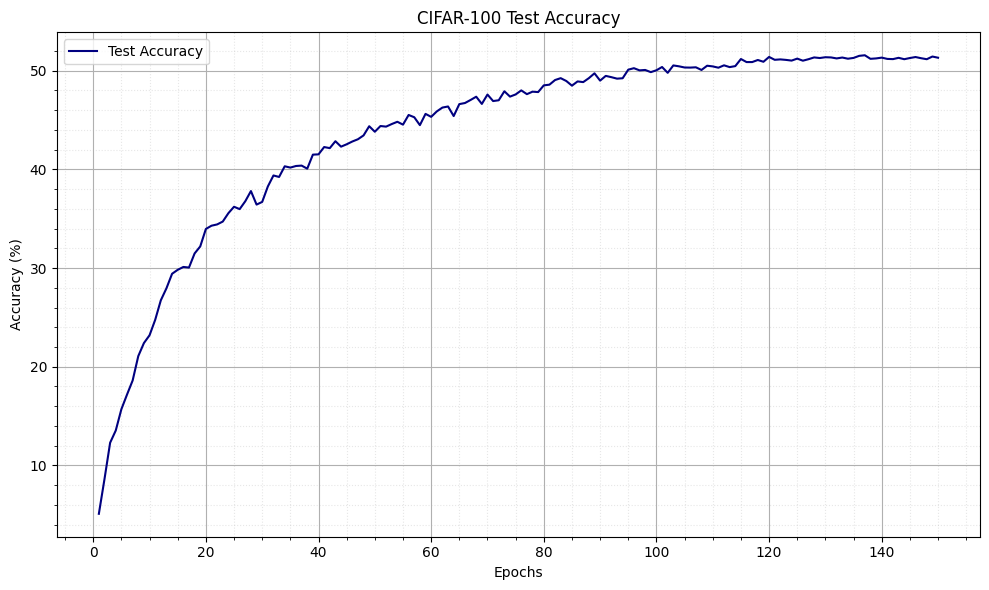

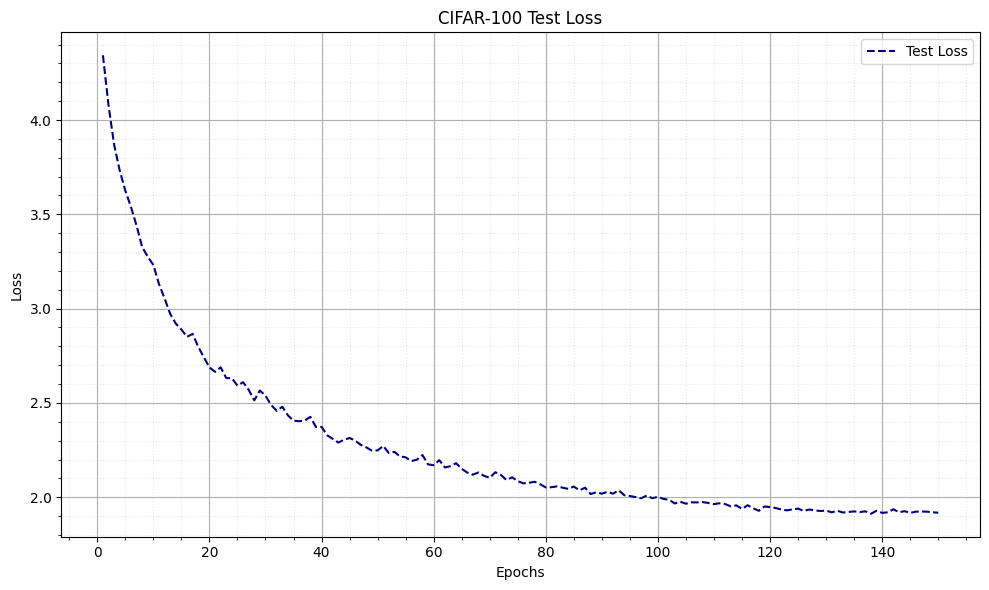

Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'


In [ ]:
def plot_training_results(test_accuracies, test_losses):
    import matplotlib.pyplot as plt

    epochs = range(1, len(test_accuracies) + 1)

    # Plot and save Test Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_accuracies, color='navy', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('CIFAR-100 Test Accuracy')
    plt.legend()
    plt.grid(True)
    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    # Improve layout
    plt.tight_layout()
    # Save plot
    plt.savefig('test_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)
    # Display plot
    plt.show()
    plt.close()

    # Plot and save Test Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_losses, color='navy', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CIFAR-100 Test Loss')
    plt.legend()
    plt.grid(True)
    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    # Improve layout
    plt.tight_layout()
    # Save plot
    plt.savefig('test_loss.pdf', format='pdf', bbox_inches='tight', dpi=300)
    # Display plot
    plt.show()
    plt.close()

    print("Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'")

# Call the plotting function after training
plot_training_results(test_accuracies, test_losses)

**HYPERPARAMETERS: learning_rate == 0.01 weight_decay == 0.0004**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Number of validation samples: {(val_size)}")

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of testing samples: 10000
Number of validation samples: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after first conv layer
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after second conv layer
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0004)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)



In [ ]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()


    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()


    val_loss /= len(validationloader)
    test_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    scheduler.step()

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and test accuracy
    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/150
Training Loss: 4.2608, Validation Loss: 3.9139
Test Loss: 3.8706, Test Accuracy: 10.95%
Epoch 2/150
Training Loss: 3.9226, Validation Loss: 3.6595
Test Loss: 3.5821, Test Accuracy: 13.69%
Epoch 3/150
Training Loss: 3.7511, Validation Loss: 3.4640
Test Loss: 3.3899, Test Accuracy: 17.69%
Epoch 4/150
Training Loss: 3.5970, Validation Loss: 3.3191
Test Loss: 3.2221, Test Accuracy: 21.72%
Epoch 5/150
Training Loss: 3.4884, Validation Loss: 3.2404
Test Loss: 3.1556, Test Accuracy: 21.37%
Epoch 6/150
Training Loss: 3.3828, Validation Loss: 3.0818
Test Loss: 2.9396, Test Accuracy: 26.78%
Epoch 7/150
Training Loss: 3.2748, Validation Loss: 2.9779
Test Loss: 2.8510, Test Accuracy: 27.27%
Epoch 8/150
Training Loss: 3.2046, Validation Loss: 2.9273
Test Loss: 2.7801, Test Accuracy: 29.23%
Epoch 9/150
Training Loss: 3.1177, Validation Loss: 2.8576
Test Loss: 2.6831, Test Accuracy: 30.74%
Epoch 10/150
Training Loss: 3.0525, Validation Loss: 2.7909
Test Loss: 2.6482, Test Accuracy: 32.17%

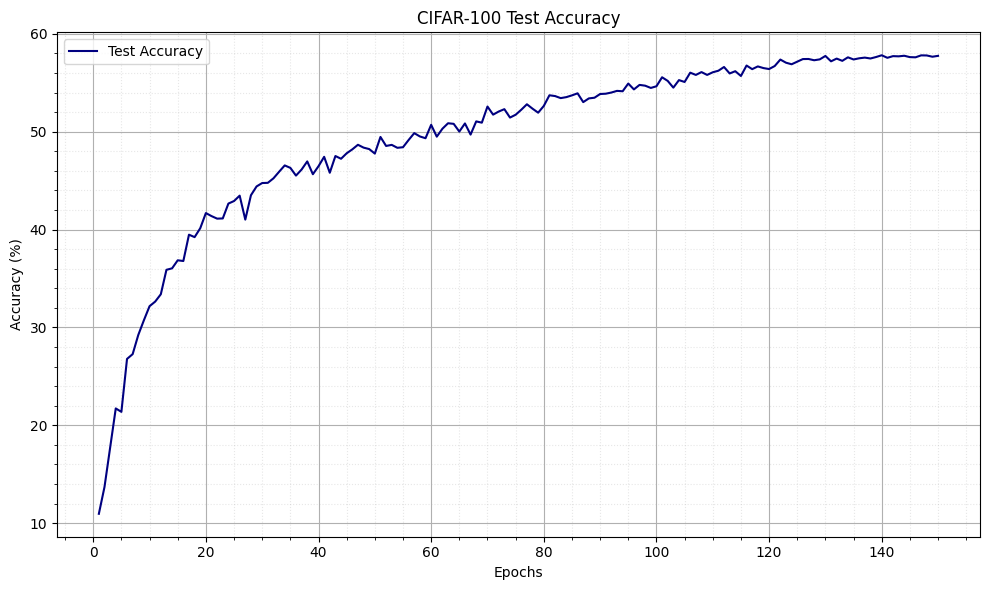

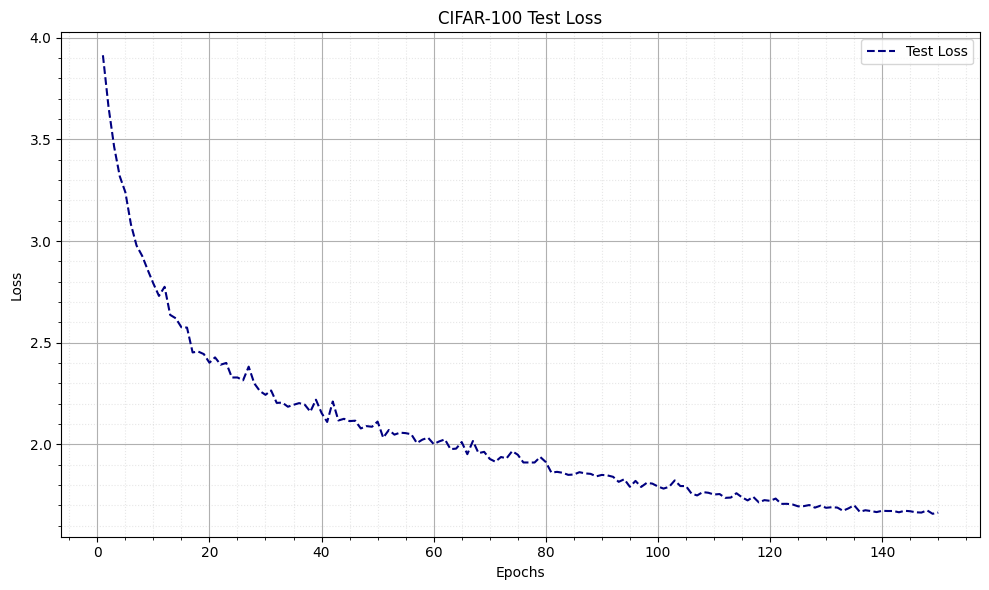

Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'


In [ ]:
def plot_training_results(test_accuracies, test_losses):
    import matplotlib.pyplot as plt

    epochs = range(1, len(test_accuracies) + 1)

    # Plot and save Test Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_accuracies, color='navy', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('CIFAR-100 Test Accuracy')
    plt.legend()
    plt.grid(True)
    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    # Improve layout
    plt.tight_layout()
    # Save plot
    plt.savefig('test_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)
    # Display plot
    plt.show()
    plt.close()

    # Plot and save Test Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_losses, color='navy', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CIFAR-100 Test Loss')
    plt.legend()
    plt.grid(True)
    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    # Improve layout
    plt.tight_layout()
    # Save plot
    plt.savefig('test_loss.pdf', format='pdf', bbox_inches='tight', dpi=300)
    # Display plot
    plt.show()
    plt.close()

    print("Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'")

# Call the plotting function after training
plot_training_results(test_accuracies, test_losses)

**HYPERPARAMETERS: learning_rate == 0.01 weight_decay == 0.0001**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Number of validation samples: {(val_size)}")

100%|██████████| 169M/169M [00:02<00:00, 57.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of testing samples: 10000
Number of validation samples: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after first conv layer
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after second conv layer
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)



In [ ]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()


    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()


    val_loss /= len(validationloader)
    test_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    scheduler.step()

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and test accuracy
    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/150
Training Loss: 4.2864, Validation Loss: 3.9114
Test Loss: 3.8754, Test Accuracy: 10.80%
Epoch 2/150
Training Loss: 3.9400, Validation Loss: 3.6612
Test Loss: 3.6200, Test Accuracy: 13.31%
Epoch 3/150
Training Loss: 3.7735, Validation Loss: 3.5019
Test Loss: 3.4490, Test Accuracy: 16.69%
Epoch 4/150
Training Loss: 3.6381, Validation Loss: 3.3249
Test Loss: 3.2103, Test Accuracy: 21.38%
Epoch 5/150
Training Loss: 3.5069, Validation Loss: 3.2506
Test Loss: 3.1713, Test Accuracy: 21.88%
Epoch 6/150
Training Loss: 3.3793, Validation Loss: 3.0760
Test Loss: 2.9736, Test Accuracy: 25.25%
Epoch 7/150
Training Loss: 3.2878, Validation Loss: 2.9668
Test Loss: 2.8569, Test Accuracy: 27.32%
Epoch 8/150
Training Loss: 3.1848, Validation Loss: 2.8800
Test Loss: 2.7320, Test Accuracy: 29.51%
Epoch 9/150
Training Loss: 3.1119, Validation Loss: 2.8466
Test Loss: 2.7014, Test Accuracy: 30.77%
Epoch 10/150
Training Loss: 3.0495, Validation Loss: 2.7208
Test Loss: 2.5946, Test Accuracy: 31.93%

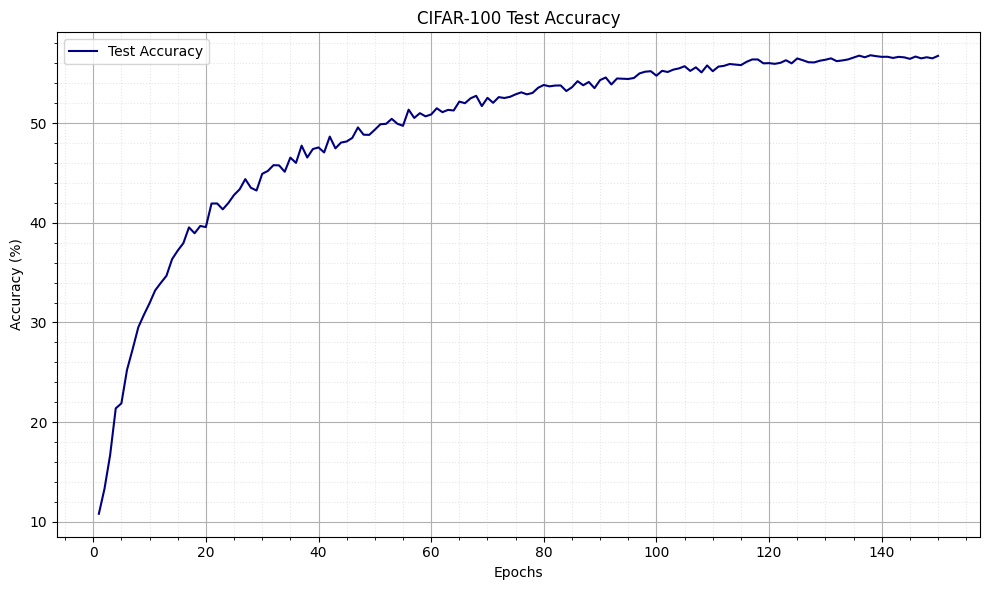

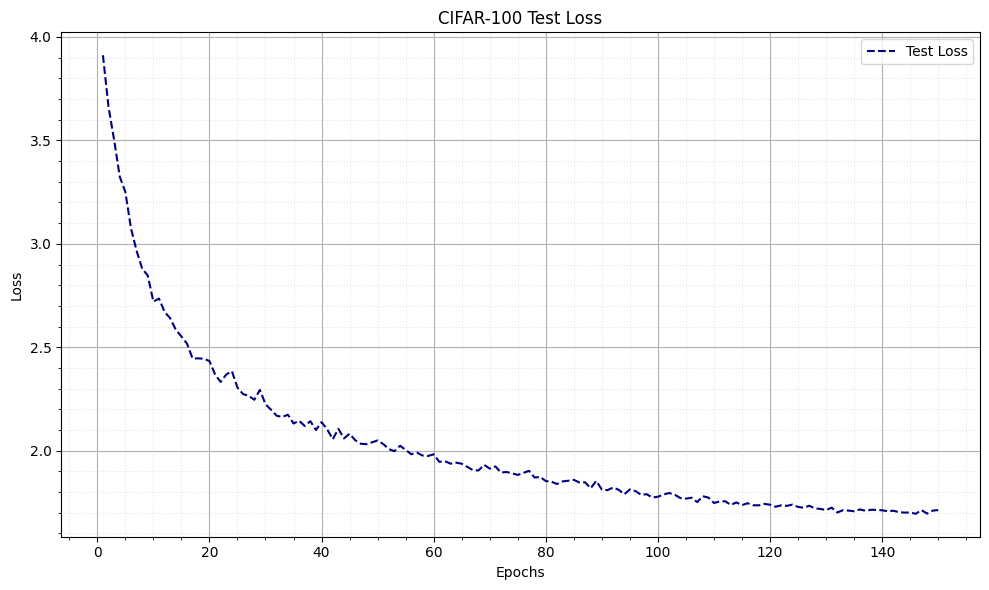

Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'


In [ ]:
def plot_training_results(test_accuracies, test_losses):
    import matplotlib.pyplot as plt

    epochs = range(1, len(test_accuracies) + 1)

    # Plot and save Test Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_accuracies, color='navy', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('CIFAR-100 Test Accuracy')
    plt.legend()
    plt.grid(True)
    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    # Improve layout
    plt.tight_layout()
    # Save plot
    plt.savefig('test_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)
    # Display plot
    plt.show()
    plt.close()

    # Plot and save Test Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_losses, color='navy', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CIFAR-100 Test Loss')
    plt.legend()
    plt.grid(True)
    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.3)
    # Improve layout
    plt.tight_layout()
    # Save plot
    plt.savefig('test_loss.pdf', format='pdf', bbox_inches='tight', dpi=300)
    # Display plot
    plt.show()
    plt.close()

    print("Plots have been saved as 'test_accuracy.pdf' and 'test_loss.pdf'")

# Call the plotting function after training
plot_training_results(test_accuracies, test_losses)

***STEPLR LEARNING RATE SCHEDUALER***

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, ExponentialLR

transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Number of validation samples: {(val_size)}")

100%|██████████| 169M/169M [00:18<00:00, 9.13MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of testing samples: 10000
Number of validation samples: 10000


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after first conv layer
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after second conv layer
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0004)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


In [3]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()


    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()


    val_loss /= len(validationloader)
    test_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    scheduler.step()

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and test accuracy
    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/150
Training Loss: 4.2819, Validation Loss: 3.8802
Test Loss: 3.8473, Test Accuracy: 9.29%
Epoch 2/150
Training Loss: 3.9302, Validation Loss: 3.6444
Test Loss: 3.5984, Test Accuracy: 14.09%
Epoch 3/150
Training Loss: 3.7576, Validation Loss: 3.4853
Test Loss: 3.4249, Test Accuracy: 17.10%
Epoch 4/150
Training Loss: 3.6020, Validation Loss: 3.3090
Test Loss: 3.2271, Test Accuracy: 20.34%
Epoch 5/150
Training Loss: 3.4763, Validation Loss: 3.1677
Test Loss: 3.0674, Test Accuracy: 23.54%
Epoch 6/150
Training Loss: 3.3611, Validation Loss: 3.0691
Test Loss: 2.9589, Test Accuracy: 26.58%
Epoch 7/150
Training Loss: 3.2674, Validation Loss: 2.9872
Test Loss: 2.8593, Test Accuracy: 27.56%
Epoch 8/150
Training Loss: 3.1803, Validation Loss: 2.8955
Test Loss: 2.7544, Test Accuracy: 30.11%
Epoch 9/150
Training Loss: 3.1074, Validation Loss: 2.8221
Test Loss: 2.6811, Test Accuracy: 30.24%
Epoch 10/150
Training Loss: 3.0469, Validation Loss: 2.7883
Test Loss: 2.6736, Test Accuracy: 30.82%


**EXPONENTIAL DECAY **

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, ExponentialLR

transform_train= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")
print(f"Number of validation samples: {(val_size)}")

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 40000
Number of testing samples: 10000
Number of validation samples: 10000


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after first conv layer
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization after second conv layer
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0004)

# Learning rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.95)  # Reduces learning rate by factor of 0.95 every epoch


In [6]:

train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_train_loss += loss.item()


    avg_train_loss = running_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()


    val_loss /= len(validationloader)
    test_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    scheduler.step()

    # Testing Phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average test loss and test accuracy
    test_loss /= len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/150
Training Loss: 4.2633, Validation Loss: 3.8879
Test Loss: 3.8445, Test Accuracy: 9.98%
Epoch 2/150
Training Loss: 3.9218, Validation Loss: 3.6417
Test Loss: 3.5747, Test Accuracy: 14.28%
Epoch 3/150
Training Loss: 3.7522, Validation Loss: 3.4667
Test Loss: 3.3915, Test Accuracy: 17.80%
Epoch 4/150
Training Loss: 3.6048, Validation Loss: 3.3351
Test Loss: 3.2291, Test Accuracy: 20.42%
Epoch 5/150
Training Loss: 3.4754, Validation Loss: 3.1635
Test Loss: 3.0704, Test Accuracy: 23.59%
Epoch 6/150
Training Loss: 3.3655, Validation Loss: 3.0487
Test Loss: 2.9284, Test Accuracy: 26.14%
Epoch 7/150
Training Loss: 3.2778, Validation Loss: 3.0101
Test Loss: 2.8694, Test Accuracy: 28.05%
Epoch 8/150
Training Loss: 3.1921, Validation Loss: 2.9363
Test Loss: 2.8004, Test Accuracy: 28.74%
Epoch 9/150
Training Loss: 3.1272, Validation Loss: 2.8406
Test Loss: 2.7014, Test Accuracy: 30.70%
Epoch 10/150
Training Loss: 3.0594, Validation Loss: 2.8023
Test Loss: 2.6455, Test Accuracy: 31.85%
